# Lab 9, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The objective of this laboratory work is to develop a tracking filter of a moving object, when measurements and motion model are in different coordinate systems. This problem is typical for radio navigation systems. Important outcome of this exercise is to detect main difficulties of practical Kalman filter implementation related with instability zone of a tracking filter, and to analyze conditions under which navigation system may become blind and the filter diverges. This is important to prevent collisions and for other safety issues.

# Instability zone of a tracking filter due to ill-conditioned coordinate transformations of measurements.


Let's generate a true trajectory $X_i$ of an object that moves uniformly. Trajectory is deterministic, as no random disturbance affects a motion.

Cartesian coordinates $x_i$, $y_i$ and components of velocity $v_i^x$, $v_i^y$ are determined by:

$$
x_i = x_{i-1} + v_{i-1}^x T
$$

$$
v_{i}^x = v_{i-1}^x
$$

$$
y_i = y_{i-1} + v_{i-1}^y T
$$

$$
v_{i}^y = v_{i-1}^y
$$


In [2]:
#N is the size of trajectory
N = 26

#T is the interval between measurements
T = 2

#Now let's create the trajectory
x = np.zeros(N)
x[0] = 13500/np.sqrt(2)

y = np.zeros(N)
y[0] = 13500/np.sqrt(2)

v_x = np.zeros(N)
v_x[0] = -50

v_y = np.zeros(N)
v_y[0] = -45

for i in range(1,N):
    x[i] = x[i-1] + v_x[i-1]*T
    v_x[i] = v_x[i-1]
    y[i] = y[i-1] + v_y[i-1]*T
    v_y[i] = v_y[i-1]
    

These conditions mean that an object starts its motion at a great distance from an observer. Later we will analyze a situation in which an object starts its motion at a close distance from an observer.

We will now also generate true values of range $D$ and azimuth $\beta$:

$$
D_i = \sqrt{x_i^2 + y_i^2}
$$

$$
\beta_i = arctg \frac{x_i}{y_i}
$$

with initial values

$$
D_0 = \sqrt{x_0^2 + y_0^2}
$$

$$
\beta_0 = arctg \frac{x_0}{y_0}
$$

In [3]:
D = np.zeros(N)
B = np.zeros(N)

for i in range(N):
    D[i] = np.sqrt(x[i]**2 + y[i]**2)
    B[i] = np.arctan(x[i] / y[i])

Let's now plot generated motion in polar coordinate system

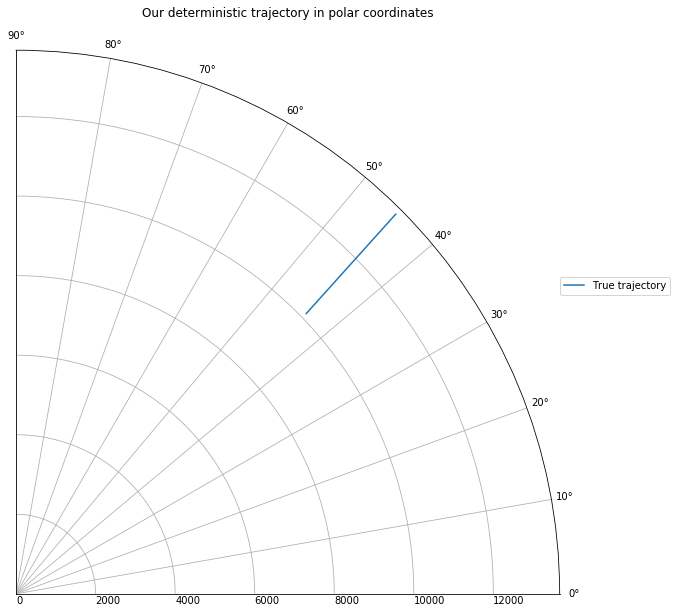

In [4]:
plt.figure(figsize=(10,10))
plt.polar(B, D)
plt.xlim(0,np.pi/2)
plt.title('Our deterministic trajectory in polar coordinates')
plt.legend(['True trajectory'], loc = (1, 0.55))
plt.show()

Now we will generate measurements $D^m$ and $\beta^m$ of range $D$ and azimuth $\beta$:

$$
D_i^m = D_i + \eta_i^D
$$

$$
\beta_i^m = \beta_i + \eta_i^\beta
$$

Where $\eta$'s are random Gaussian noises with the following variances:

$$
\sigma_\eta^D = 20
$$

$$
\sigma_\eta^\beta = 0.02
$$

Later we'll analyze other conditions

In [5]:
#noise of D
sigma_eta_D = 20
eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

#noise of beta
sigma_eta_B = 0.02
eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

#Now let's generate measurements
D_m = np.zeros(N)
B_m = np.zeros(N)

for i in range(N):
    D_m[i] = D[i] + eta_D[i]
    B_m[i] = B[i] + eta_B[i]

Let's now plot generated measurements in polar coordinate system

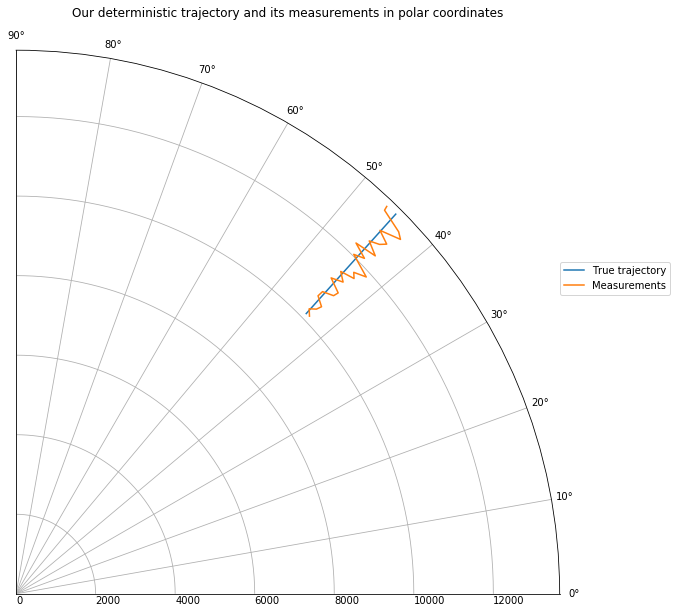

In [6]:
plt.figure(figsize=(10,10))
plt.polar(B, D)
plt.polar(B_m, D_m)
plt.xlim(0,np.pi/2)
plt.title('Our deterministic trajectory and its measurements in polar coordinates')
plt.legend(['True trajectory', 'Measurements'], loc = (1, 0.55))
plt.show()

Now we are going to transform polar coordinates $D^m$ and $\beta^m$ to Cartesian ones and get pseudo-measurements of coordinates $x$ and $y$: $x^m$ and $y^m$

In [7]:
x_m = np.zeros(N)
y_m = np.zeros(N)

for i in range(N):
    x_m[i] = D_m[i] * np.sin(B_m[i])
    y_m[i] = D_m[i] * np.cos(B_m[i])

Let's create the measurement vector $Z$ from $x^m$ and $y^m$ and state vector $X$ from $x_i$, $v_i^x$, $y_i$, $v_i^y$:

$$
Z_i = 
\begin{vmatrix}
x_i^m \\
y_i^m
\end{vmatrix}
$$

$$
X_i = 
\begin{vmatrix}
x_i \\
v_i^x \\
y_i \\
v_i^y
\end{vmatrix}
$$

In [8]:
#Making measurement vector
Z = np.zeros((N, 2, 1))
for i in range(N):
    Z[i,0] = x_m[i]
    Z[i,1] = y_m[i]
    Z[i] = np.matrix([[x_m[i]], [y_m[i]]])
    
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i,0] = x[i]
    X[i,1] = v_x[i]
    X[i,2] = y[i]
    X[i,3] = v_y[i]
    X[i] = np.matrix([[x[i]], [v_x[i]], [y[i]], [v_y[i]]])

Now we will introduce initial conditions for Kalman filter algorithm and all needed matrices

In [9]:
#Initial state vector
X[0] = np.matrix([[40000], [-20], [40000], [-20]])

#Making initial filtration error covariance matrix P[i,i] and its initial value
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
P[0] = np.matrix([[10**10, 0, 0, 0], [0, 10**10, 0, 0], [0, 0, 10**10, 0], [0, 0, 0, 10**10]])

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])

#Making an observation matrix
H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

#Making measurement error covariance matrix R
R = np.zeros((N, 2, 2))
for i in range(N):
    R[i] = np.matrix([[(sigma_eta_D**2 * (np.sin(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.cos(B_m[i]))**2), np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2)], [np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2), (sigma_eta_D**2 * (np.cos(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.sin(B_m[i]))**2)]])

Let's now develop Kalman filter algorithm to estimate state vector $X_i$ (extrapolation and filtration). At every extrapolation and filtration step we will need to calculate range $D_i$ and azimuth $\beta_i$ from extrapolated and filtered estimates.

In [10]:
#Let's start Kalman filter algorithm
D_Kalman_Predict = np.zeros(N)
B_Kalman_Predict = np.zeros(N)
D_Kalman_Filter = np.zeros(N)
B_Kalman_Filter = np.zeros(N)

e = np.zeros((N, 2, 2))
K = np.zeros((N, 4, 2))

for i in range(N):
    K[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0]]).T
for i in range(1, N):
    
    #Prediction of the state vector
    X[i] = PHI @ X[i-1]
    D_Kalman_Predict[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
    B_Kalman_Predict[i] = np.arctan(X[i,0,0] / X[i,2,0])
    
    #Prediction error covariance matrix
    P[i] = PHI @ P[i-1] @ PHI.T
    
    #Filtration
    e[i] = np.linalg.inv((H @ P[i] @ H.T + R[i]))
    K[i] = P[i] @ H.T @ e[i]
    X[i] = X[i] + K[i] @ ([Z[i] - H @ X[i]])
    D_Kalman_Filter[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
    B_Kalman_Filter[i] = np.arctan(X[i,0,0] / X[i,2,0])
    
    #Filtration error covariance matrix
    P[i] = (np.identity(np.shape(P[0])[0]) - K[i] @ H) @ P[i] 

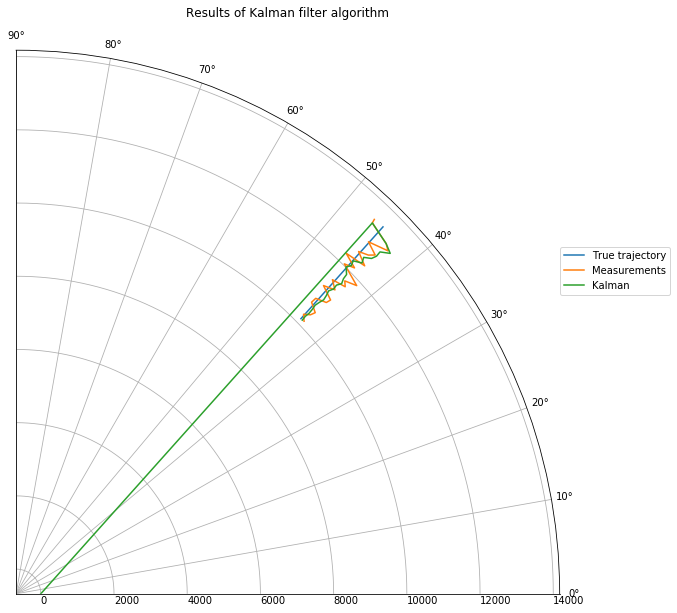

In [11]:
plt.figure(figsize=(10,10))
plt.polar(B, D)
plt.polar(B_m, D_m)
plt.polar(B_Kalman_Filter, D_Kalman_Filter)
plt.xlim(0,np.pi/2)
plt.title('Results of Kalman filter algorithm')
plt.legend(['True trajectory', 'Measurements', 'Kalman'], loc = (1, 0.55))
plt.show()

For better understanding let's plot cartesian coordinates separately

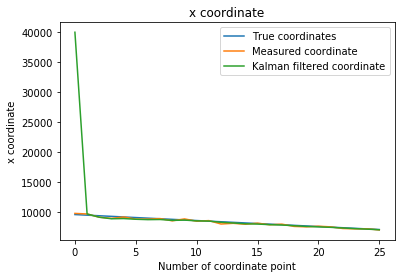

In [12]:
plt.plot(x)
plt.plot(x_m)
plt.plot(X[:,0,0])
plt.ylabel('x coordinate')
plt.xlabel('Number of coordinate point')
plt.title('x coordinate')
plt.legend(['True coordinates', 'Measured coordinate', 'Kalman filtered coordinate'], loc = 'best')
plt.show()

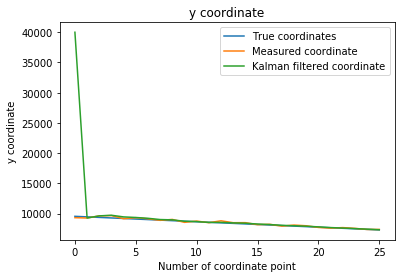

In [13]:
plt.plot(y)
plt.plot(y_m)
plt.plot(X[:,2,0])
plt.ylabel('y coordinate')
plt.xlabel('Number of coordinate point')
plt.title('y coordinate')
plt.legend(['True coordinates', 'Measured coordinate', 'Kalman filtered coordinate'], loc = 'best')
plt.show()

Thus we conclude that Kalman works alright concerning the initial state vector. Physically, the situation is as follows: the spaceship approaches our station from big distance

We will now run Kalman filter algorithm over $M$ = 500 runs and calculate true errors of extrapolation and filtration estimates of range $D$ relative to $\sigma_\eta^D$.

In [14]:
# M is the total number of runs
M=500
Errors_prediction_squared = np.zeros((M, N))
Errors_filtration_squared = np.zeros((M, N))

for j in range(M):
    #N is the size of trajectory
    N = 26

    #T is the interval between measurements
    T = 2

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 13500/np.sqrt(2)

    y = np.zeros(N)
    y[0] = 13500/np.sqrt(2)

    v_x = np.zeros(N)
    v_x[0] = -50

    v_y = np.zeros(N)
    v_y[0] = -45

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T
        v_x[i] = v_x[i-1]
        y[i] = y[i-1] + v_y[i-1]*T
        v_y[i] = v_y[i-1]
        
    D = np.zeros(N)
    B = np.zeros(N)

    for i in range(N):
        D[i] = np.sqrt(x[i]**2 + y[i]**2)
        B[i] = np.arctan(x[i] / y[i])
                  
    #noise of D
    sigma_eta_D = 20
    eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

    #noise of beta
    sigma_eta_B = 0.02
    eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

    #Now let's generate measurements
    D_m = np.zeros(N)
    B_m = np.zeros(N)

    for i in range(N):
        D_m[i] = D[i] + eta_D[i]
        B_m[i] = B[i] + eta_B[i]    
        
    x_m = np.zeros(N)
    y_m = np.zeros(N)

    for i in range(N):
        x_m[i] = D_m[i] * np.sin(B_m[i])
        y_m[i] = D_m[i] * np.cos(B_m[i])
        
    #Making measurement vector
    Z = np.zeros((N, 2, 1))
    for i in range(N):
        Z[i,0] = x_m[i]
        Z[i,1] = y_m[i]
        Z[i] = np.matrix([[x_m[i]], [y_m[i]]])

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i,0] = x[i]
        X[i,1] = v_x[i]
        X[i,2] = y[i]
        X[i,3] = v_y[i]
        X[i] = np.matrix([[x[i]], [v_x[i]], [y[i]], [v_y[i]]])
        
    #Initial state vector
    X[0] = np.matrix([[40000], [-20], [40000], [-20]])

    #Making initial filtration error covariance matrix P[i,i] and its initial value
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    P[0] = np.matrix([[10**10, 0, 0, 0], [0, 10**10, 0, 0], [0, 0, 10**10, 0], [0, 0, 0, 10**10]])

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])

    #Making an observation matrix
    H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

    #Making measurement error covariance matrix R
    R = np.zeros((N, 2, 2))
    for i in range(N):
        R[i] = np.matrix([[(sigma_eta_D**2 * (np.sin(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.cos(B_m[i]))**2), np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2)], [np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2), (sigma_eta_D**2 * (np.cos(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.sin(B_m[i]))**2)]])
    
    #Let's start Kalman filter algorithm
    D_Kalman_Predict = np.zeros(N)
    B_Kalman_Predict = np.zeros(N)
    D_Kalman_Filter = np.zeros(N)
    B_Kalman_Filter = np.zeros(N)

    e = np.zeros((N, 2, 2))
    K = np.zeros((N, 4, 2))

    for i in range(N):
        K[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0]]).T
    for i in range(1, N):

        #Prediction of the state vector
        X[i] = PHI @ X[i-1]
        D_Kalman_Predict[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Predict[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Prediction error covariance matrix
        P[i] = PHI @ P[i-1] @ PHI.T

        #Filtration
        e[i] = np.linalg.inv((H @ P[i] @ H.T + R[i]))
        K[i] = P[i] @ H.T @ e[i]
        X[i] = X[i] + K[i] @ ([Z[i] - H @ X[i]])
        D_Kalman_Filter[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Filter[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Filtration error covariance matrix
        P[i] = (np.identity(np.shape(P[0])[0]) - K[i] @ H) @ P[i] 
        
        #Errors gathering
        for i in range(N):
            Errors_prediction_squared[j, i] = (D_Kalman_Predict[i] - D_m[i])**2
            Errors_filtration_squared[j, i] = (D_Kalman_Filter[i] - D_m[i])**2
        

Fin_Err_prediction_squared = np.zeros(N)
Fin_Err_filtration_squared = np.zeros(N)
for i in range(N):
    for j in range(M):
        Fin_Err_prediction_squared[i] += (1/(M-1))*Errors_prediction_squared[j, i]
        Fin_Err_filtration_squared[i] += (1/(M-1))*Errors_filtration_squared[j, i]

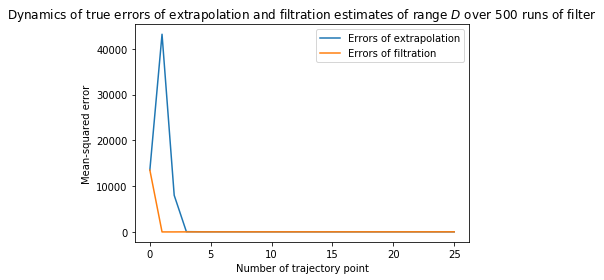

In [15]:
plt.plot(np.sqrt(Fin_Err_prediction_squared))
plt.plot(np.sqrt(Fin_Err_filtration_squared))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of range $D$ over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

Errors of extrapolation first increase and then decrease with time whereas errors of filtration start decreasing from the very beginning

We will now run Kalman filter algorithm over $M$ = 500 runs and calculate true errors of extrapolation and filtration estimates of range $\beta$ relative to $\sigma_\eta^\beta$.

In [16]:
# M is the total number of runs
M=500
Errors_prediction_squared = np.zeros((M, N))
Errors_filtration_squared = np.zeros((M, N))

for j in range(M):
    #N is the size of trajectory
    N = 26

    #T is the interval between measurements
    T = 2

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 13500/np.sqrt(2)

    y = np.zeros(N)
    y[0] = 13500/np.sqrt(2)

    v_x = np.zeros(N)
    v_x[0] = -50

    v_y = np.zeros(N)
    v_y[0] = -45

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T
        v_x[i] = v_x[i-1]
        y[i] = y[i-1] + v_y[i-1]*T
        v_y[i] = v_y[i-1]
        
    D = np.zeros(N)
    B = np.zeros(N)

    for i in range(N):
        D[i] = np.sqrt(x[i]**2 + y[i]**2)
        B[i] = np.arctan(x[i] / y[i])
                  
    #noise of D
    sigma_eta_D = 20
    eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

    #noise of beta
    sigma_eta_B = 0.02
    eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

    #Now let's generate measurements
    D_m = np.zeros(N)
    B_m = np.zeros(N)

    for i in range(N):
        D_m[i] = D[i] + eta_D[i]
        B_m[i] = B[i] + eta_B[i]    
        
    x_m = np.zeros(N)
    y_m = np.zeros(N)

    for i in range(N):
        x_m[i] = D_m[i] * np.sin(B_m[i])
        y_m[i] = D_m[i] * np.cos(B_m[i])
        
    #Making measurement vector
    Z = np.zeros((N, 2, 1))
    for i in range(N):
        Z[i,0] = x_m[i]
        Z[i,1] = y_m[i]
        Z[i] = np.matrix([[x_m[i]], [y_m[i]]])

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i,0] = x[i]
        X[i,1] = v_x[i]
        X[i,2] = y[i]
        X[i,3] = v_y[i]
        X[i] = np.matrix([[x[i]], [v_x[i]], [y[i]], [v_y[i]]])
        
    #Initial state vector
    X[0] = np.matrix([[40000], [-20], [40000], [-20]])

    #Making initial filtration error covariance matrix P[i,i] and its initial value
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    P[0] = np.matrix([[10**10, 0, 0, 0], [0, 10**10, 0, 0], [0, 0, 10**10, 0], [0, 0, 0, 10**10]])

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])

    #Making an observation matrix
    H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

    #Making measurement error covariance matrix R
    R = np.zeros((N, 2, 2))
    for i in range(N):
        R[i] = np.matrix([[(sigma_eta_D**2 * (np.sin(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.cos(B_m[i]))**2), np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2)], [np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2), (sigma_eta_D**2 * (np.cos(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.sin(B_m[i]))**2)]])
    
    #Let's start Kalman filter algorithm
    D_Kalman_Predict = np.zeros(N)
    B_Kalman_Predict = np.zeros(N)
    D_Kalman_Filter = np.zeros(N)
    B_Kalman_Filter = np.zeros(N)

    e = np.zeros((N, 2, 2))
    K = np.zeros((N, 4, 2))

    for i in range(N):
        K[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0]]).T
    for i in range(1, N):

        #Prediction of the state vector
        X[i] = PHI @ X[i-1]
        D_Kalman_Predict[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Predict[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Prediction error covariance matrix
        P[i] = PHI @ P[i-1] @ PHI.T

        #Filtration
        e[i] = np.linalg.inv((H @ P[i] @ H.T + R[i]))
        K[i] = P[i] @ H.T @ e[i]
        X[i] = X[i] + K[i] @ ([Z[i] - H @ X[i]])
        D_Kalman_Filter[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Filter[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Filtration error covariance matrix
        P[i] = (np.identity(np.shape(P[0])[0]) - K[i] @ H) @ P[i] 
        
        #Errors gathering
        for i in range(N):
            Errors_prediction_squared[j, i] = (B_Kalman_Predict[i] - B_m[i])**2
            Errors_filtration_squared[j, i] = (B_Kalman_Filter[i] - B_m[i])**2
        

Fin_Err_prediction_squared = np.zeros(N)
Fin_Err_filtration_squared = np.zeros(N)
for i in range(N):
    for j in range(M):
        Fin_Err_prediction_squared[i] += (1/(M-1))*Errors_prediction_squared[j, i]
        Fin_Err_filtration_squared[i] += (1/(M-1))*Errors_filtration_squared[j, i]

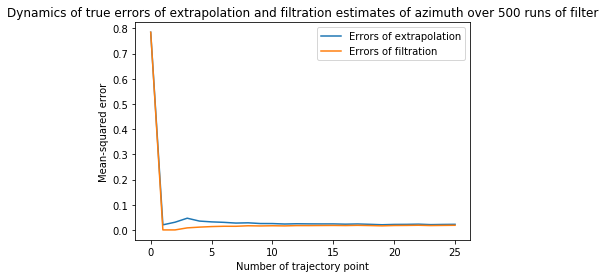

In [17]:
plt.plot(np.sqrt(Fin_Err_prediction_squared))
plt.plot(np.sqrt(Fin_Err_filtration_squared))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of azimuth over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

Errors of $\beta$ behave almost the same, excluding the fact that errors extrapolation suffer a small rise in the beginning before decreasing

For better understanding of the situation let's also plot azimuth $\beta$ through the whole trajectory

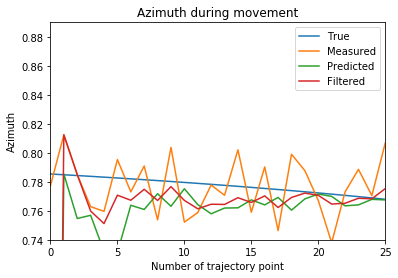

In [18]:
plt.plot(B)
plt.plot(B_m)
plt.plot(B_Kalman_Predict)
plt.plot(B_Kalman_Filter)
plt.title('Azimuth during movement')
plt.ylabel('Azimuth')
plt.xlabel('Number of trajectory point')
plt.legend(['True', 'Measured','Predicted','Filtered'], loc = 'best')
plt.ylim((0.74, 0.89))
plt.xlim((0, 25))
plt.show()

Now we plan to analyze dependence of coordinate $x$ on azimuth $\beta$. According to coordinate transformation the relation should be as follows:
$$
x = D sin \beta
$$

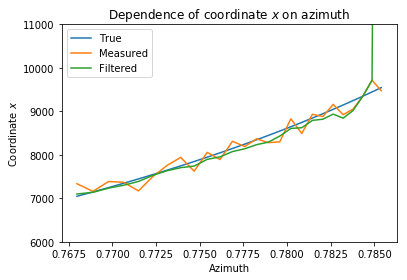

In [19]:
plt.plot(B, x)
plt.plot(B, x_m)
plt.plot(B, X[:,0,0])
plt.title('Dependence of coordinate $x$ on azimuth')
plt.ylabel('Coordinate $x$')
plt.xlabel('Azimuth')
plt.legend(['True', 'Measured','Filtered'], loc = 'best')
plt.ylim((6000, 11000))
plt.show()

The dependence is close to linear which means that linearization errors are insignificant.

Let's now calculate condition number of covariance matrix $R$ which is $\cfrac{\lambda_{max}}{\lambda_{min}}$ over the observation interval.

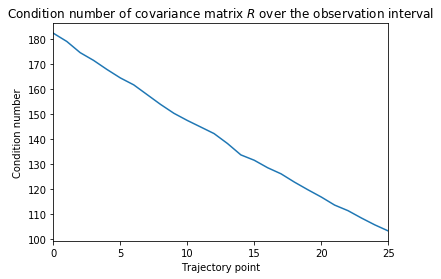

In [20]:
plt.plot(np.linalg.cond(R))
plt.title('Condition number of covariance matrix $R$ over the observation interval')
plt.ylabel('Condition number')
plt.xlabel('Trajectory point')
plt.xlim((0, 25))
plt.show()

Our matrix is ill-conditioned

Now we will analyze filter gain $K$. Dimension of filter gain in this case is 4x2. We are going to plot K(1,1). It's important to note that values of K(1,1) over observation interval don’t always belong to interval (0,1). This is related to the fact that matrix $R$ depends on polar measurements that have errors. Ways to adjust filter gain $K$ to be in the required range (0,1) can be analyzed, but this is not the goal of current lab.

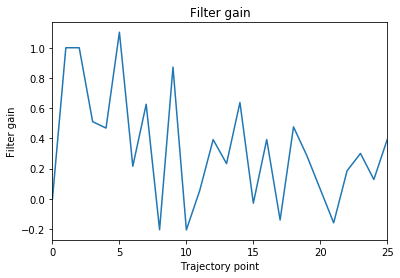

In [21]:
plt.plot(K[:, 0, 0])
plt.title('Filter gain')
plt.ylabel('Filter gain')
plt.xlabel('Trajectory point')
plt.xlim((0, 25))
plt.show()

## Steps 19 and 20
Now we'll run the filter again over $M$ = 500 runs but use other initial conditions to generate a trajectory:

$$
x_0 = \frac{3500}{\sqrt{2}}
$$

$$
y_0 = \frac{3500}{\sqrt{2}}
$$

This means that an object starts it motion at a quite close distance from an observer.

But to generate polar measurements we'll use different sigmas

$$
\sigma_\eta^D = 50
$$

$$
\sigma_\eta^\beta = 0.0015
$$

In [22]:
# M is the total number of runs
M=500
Errors_prediction_squared_D = np.zeros((M, N))
Errors_filtration_squared_D = np.zeros((M, N))
Errors_prediction_squared_B = np.zeros((M, N))
Errors_filtration_squared_B = np.zeros((M, N))

for j in range(M):
    #N is the size of trajectory
    N = 26

    #T is the interval between measurements
    T = 2

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 3500/np.sqrt(2)

    y = np.zeros(N)
    y[0] = 3500/np.sqrt(2)

    v_x = np.zeros(N)
    v_x[0] = -50

    v_y = np.zeros(N)
    v_y[0] = -45

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T
        v_x[i] = v_x[i-1]
        y[i] = y[i-1] + v_y[i-1]*T
        v_y[i] = v_y[i-1]
        
    D = np.zeros(N)
    B = np.zeros(N)

    for i in range(N):
        D[i] = np.sqrt(x[i]**2 + y[i]**2)
        B[i] = np.arctan(x[i] / y[i])
                  
    #noise of D
    sigma_eta_D = 50
    eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

    #noise of beta
    sigma_eta_B = 0.0015
    eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

    #Now let's generate measurements
    D_m = np.zeros(N)
    B_m = np.zeros(N)

    for i in range(N):
        D_m[i] = D[i] + eta_D[i]
        B_m[i] = B[i] + eta_B[i]    
        
    x_m = np.zeros(N)
    y_m = np.zeros(N)

    for i in range(N):
        x_m[i] = D_m[i] * np.sin(B_m[i])
        y_m[i] = D_m[i] * np.cos(B_m[i])
        
    #Making measurement vector
    Z = np.zeros((N, 2, 1))
    for i in range(N):
        Z[i,0] = x_m[i]
        Z[i,1] = y_m[i]
        Z[i] = np.matrix([[x_m[i]], [y_m[i]]])

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i,0] = x[i]
        X[i,1] = v_x[i]
        X[i,2] = y[i]
        X[i,3] = v_y[i]
        X[i] = np.matrix([[x[i]], [v_x[i]], [y[i]], [v_y[i]]])
        
    #Initial state vector
    X[0] = np.matrix([[40000], [-20], [40000], [-20]])

    #Making initial filtration error covariance matrix P[i,i] and its initial value
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
    P[0] = np.matrix([[10**10, 0, 0, 0], [0, 10**10, 0, 0], [0, 0, 10**10, 0], [0, 0, 0, 10**10]])

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])

    #Making an observation matrix
    H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

    #Making measurement error covariance matrix R
    R = np.zeros((N, 2, 2))
    for i in range(N):
        R[i] = np.matrix([[(sigma_eta_D**2 * (np.sin(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.cos(B_m[i]))**2), np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2)], [np.sin(B_m[i]) * np.cos(B_m[i]) * (sigma_eta_D**2 - D_m[i]**2 * sigma_eta_B**2), (sigma_eta_D**2 * (np.cos(B_m[i]))**2) + (D_m[i]**2 * (sigma_eta_B)**2 * (np.sin(B_m[i]))**2)]])
    
    #Let's start Kalman filter algorithm
    D_Kalman_Predict = np.zeros(N)
    B_Kalman_Predict = np.zeros(N)
    D_Kalman_Filter = np.zeros(N)
    B_Kalman_Filter = np.zeros(N)

    e = np.zeros((N, 2, 2))
    K = np.zeros((N, 4, 2))

    for i in range(N):
        K[i] = np.matrix([[0, 0, 0, 0], [0, 0, 0, 0]]).T
    for i in range(1, N):

        #Prediction of the state vector
        X[i] = PHI @ X[i-1]
        D_Kalman_Predict[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Predict[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Prediction error covariance matrix
        P[i] = PHI @ P[i-1] @ PHI.T

        #Filtration
        e[i] = np.linalg.inv((H @ P[i] @ H.T + R[i]))
        K[i] = P[i] @ H.T @ e[i]
        X[i] = X[i] + K[i] @ ([Z[i] - H @ X[i]])
        D_Kalman_Filter[i] = np.sqrt(X[i,0,0]**2 + X[i,2,0]**2)
        B_Kalman_Filter[i] = np.arctan(X[i,0,0] / X[i,2,0])

        #Filtration error covariance matrix
        P[i] = (np.identity(np.shape(P[0])[0]) - K[i] @ H) @ P[i] 
        
        #Errors gathering
        for i in range(N):
            Errors_prediction_squared_B[j, i] = (B_Kalman_Predict[i] - B[i])**2
            Errors_filtration_squared_B[j, i] = (B_Kalman_Filter[i] - B[i])**2
            Errors_prediction_squared_D[j, i] = (D_Kalman_Predict[i] - D_m[i])**2
            Errors_filtration_squared_D[j, i] = (D_Kalman_Filter[i] - D_m[i])**2
        

Fin_Err_prediction_squared_D = np.zeros(N)
Fin_Err_filtration_squared_D = np.zeros(N)
Fin_Err_prediction_squared_B = np.zeros(N)
Fin_Err_filtration_squared_B = np.zeros(N)
for i in range(N):
    for j in range(M):
        Fin_Err_prediction_squared_D[i] += (1/(M-1))*Errors_prediction_squared_D[j, i]
        Fin_Err_filtration_squared_D[i] += (1/(M-1))*Errors_filtration_squared_D[j, i]
        Fin_Err_prediction_squared_B[i] += (1/(M-1))*Errors_prediction_squared_B[j, i]
        Fin_Err_filtration_squared_B[i] += (1/(M-1))*Errors_filtration_squared_B[j, i]

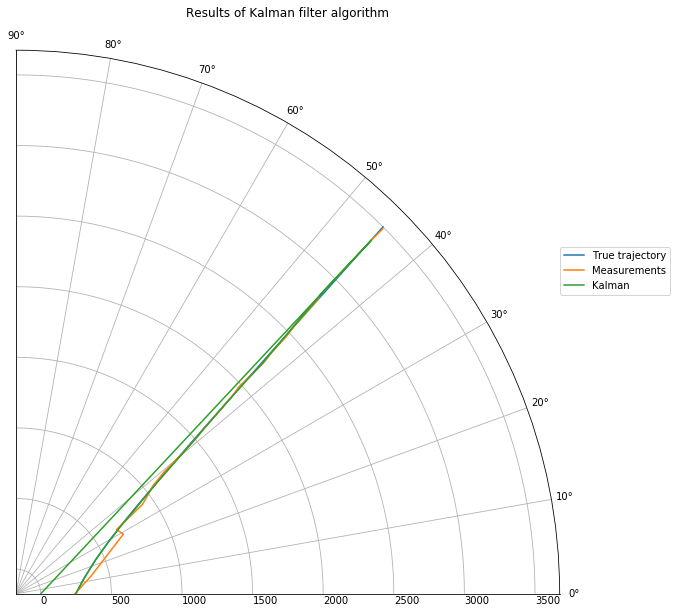

In [23]:
plt.figure(figsize=(10,10))
plt.polar(B, D)
plt.polar(B_m, D_m)
plt.polar(B_Kalman_Filter, D_Kalman_Filter)
plt.xlim(0,np.pi/2)
plt.title('Results of Kalman filter algorithm')
plt.legend(['True trajectory', 'Measurements', 'Kalman'], loc = (1, 0.55))
plt.show()

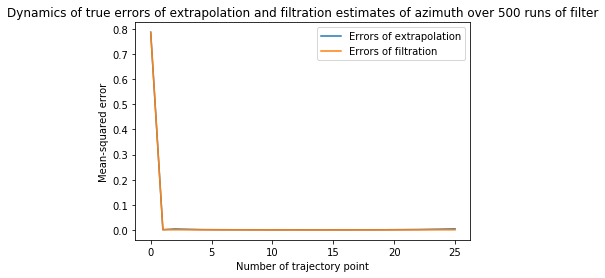

In [24]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_B))
plt.plot(np.sqrt(Fin_Err_filtration_squared_B))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of azimuth over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

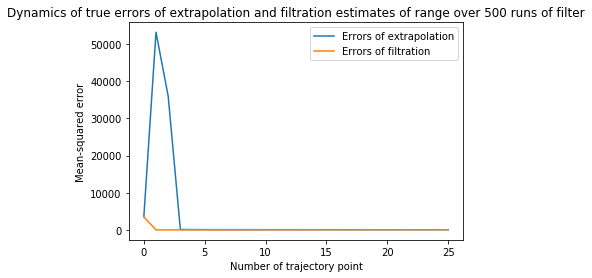

In [25]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_D))
plt.plot(np.sqrt(Fin_Err_filtration_squared_D))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of range over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

Errors of azimuth become very small instantly, errors of range strangely behave the same way as they used to.

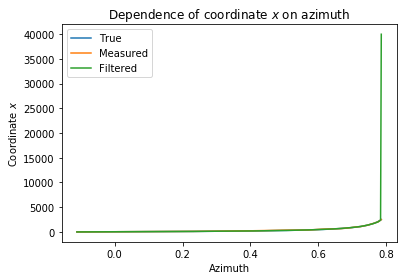

In [26]:
plt.plot(B, x)
plt.plot(B, x_m)
plt.plot(B, X[:,0,0])
plt.title('Dependence of coordinate $x$ on azimuth')
plt.ylabel('Coordinate $x$')
plt.xlabel('Azimuth')
plt.legend(['True', 'Measured','Filtered'], loc = 'best')
plt.show()

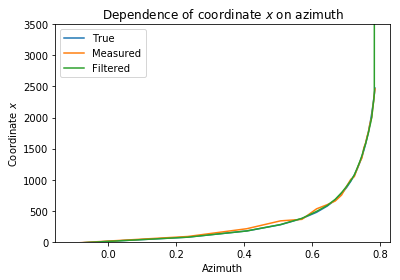

In [27]:
plt.plot(B, x)
plt.plot(B, x_m)
plt.plot(B, X[:,0,0])
plt.title('Dependence of coordinate $x$ on azimuth')
plt.ylabel('Coordinate $x$')
plt.xlabel('Azimuth')
plt.legend(['True', 'Measured','Filtered'], loc = 'best')
plt.ylim((0, 3500))
plt.show()

The dependence is nonlinear so linearization errors are significant

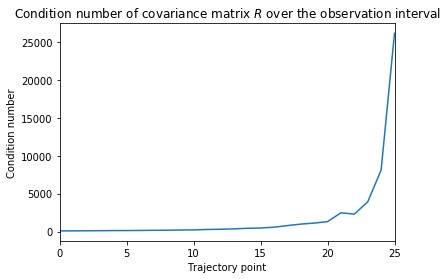

In [28]:
plt.plot(np.linalg.cond(R))
plt.title('Condition number of covariance matrix $R$ over the observation interval')
plt.ylabel('Condition number')
plt.xlabel('Trajectory point')
plt.xlim((0, 25))
plt.show()

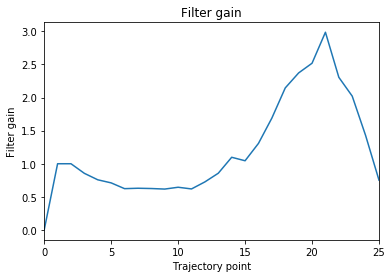

In [29]:
plt.plot(K[:, 0, 0])
plt.title('Filter gain')
plt.ylabel('Filter gain')
plt.xlabel('Trajectory point')
plt.xlim((0, 25))
plt.show()

When condition number is less than 1 and the $x-\beta$ dependence is non-linear, the error is big

# Final conclusion:

When coordinates are closer to zero and the condition number is big, a navigation system can become blind. I think that the greatest influence introduces the combination of factors: closeness to the station and conditional number